In [91]:
import numpy as np
import pandas as pd
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Conv1D,MaxPooling1D,Bidirectional,Dropout
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
data=pd.read_csv('Airline_Reviews.csv')
data.head()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


In [3]:
data.shape

(23171, 20)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              23171 non-null  int64  
 1   Airline Name            23171 non-null  object 
 2   Overall_Rating          23171 non-null  object 
 3   Review_Title            23171 non-null  object 
 4   Review Date             23171 non-null  object 
 5   Verified                23171 non-null  bool   
 6   Review                  23171 non-null  object 
 7   Aircraft                7129 non-null   object 
 8   Type Of Traveller       19433 non-null  object 
 9   Seat Type               22075 non-null  object 
 10  Route                   19343 non-null  object 
 11  Date Flown              19417 non-null  object 
 12  Seat Comfort            19016 non-null  float64
 13  Cabin Staff Service     18911 non-null  float64
 14  Food & Beverages        14500 non-null

In [5]:
data.isnull().values.any()

True

In [6]:
data.isnull().sum()

Unnamed: 0                    0
Airline Name                  0
Overall_Rating                0
Review_Title                  0
Review Date                   0
Verified                      0
Review                        0
Aircraft                  16042
Type Of Traveller          3738
Seat Type                  1096
Route                      3828
Date Flown                 3754
Seat Comfort               4155
Cabin Staff Service        4260
Food & Beverages           8671
Ground Service             4793
Inflight Entertainment    12342
Wifi & Connectivity       17251
Value For Money            1066
Recommended                   0
dtype: int64

In [7]:
df=data['Review']

In [8]:
df.head()

0      Moroni to Moheli. Turned out to be a pretty ...
1     Moroni to Anjouan. It is a very small airline...
2      Anjouan to Dzaoudzi. A very small airline an...
3      Please do a favor yourself and do not fly wi...
4     Do not book a flight with this airline! My fr...
Name: Review, dtype: object

In [9]:
df=pd.DataFrame(df,columns=['Review'])

In [10]:
df.head()

,Review
0,Moroni to Moheli. Turned out to be a pretty ...
1,Moroni to Anjouan. It is a very small airline...
2,Anjouan to Dzaoudzi. A very small airline an...
3,Please do a favor yourself and do not fly wi...
4,Do not book a flight with this airline! My fr...


In [11]:
df.shape

(23171, 1)

In [12]:
df['Review'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 23171 entries, 0 to 23170
Series name: Review
Non-Null Count  Dtype 
--------------  ----- 
23171 non-null  object
dtypes: object(1)
memory usage: 181.1+ KB


In [13]:
df.duplicated().sum()

125

In [14]:
df=df.drop_duplicates()

In [15]:
df.duplicated().sum()

0

In [16]:
df['Review']

0          Moroni to Moheli. Turned out to be a pretty ...
1         Moroni to Anjouan. It is a very small airline...
2          Anjouan to Dzaoudzi. A very small airline an...
3          Please do a favor yourself and do not fly wi...
4         Do not book a flight with this airline! My fr...
                               ...                        
23166     Bangkok to Tokyo. I’ve flown many low cost ai...
23167      Avoid at all costs. I booked flights to go f...
23168      Flight was leaving at 23.15 and after an hou...
23169     Zipair is JAL’s budget airline. They don’t ha...
23170      They lied about connection in Narita and we ...
Name: Review, Length: 23046, dtype: object

In [17]:
def text_preprocess(sen):
    TAG_RE=re.compile('[><^+]')
    sentence=TAG_RE.sub('',sen)
    sentence=sentence.lower()
    sentence=re.sub('[^A-Za-z]',' ',sentence)
    sentence=re.sub('\s+[A-Za-z]\s+',' ',sentence)
    sentence=re.sub('\s+',' ',sentence)
    pattern=re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence=pattern.sub('',sentence)
    return sentence

In [18]:
preprocessed_texts=[]
sentence=df['Review'].tolist()
for sen in sentence:
    preprocessed_texts.append(text_preprocess(sen))

In [19]:
preprocessed_texts[3]

' please favor fly adria route munich pristina july lost luggage days row despite numerous phone calls able locate days later luggage arrived destination completely ruined applying compensation ignored request foolishly booked another flight euros frankfurt pristina september cancelled flight reason hours departure desperate phone calls customer service get anything rerouting compensation etc responded never fly adria disgrace shame adria constantly deceiving customers '

In [20]:
preprocessed_texts=np.array(preprocessed_texts)

In [21]:
preprocessed_texts.shape

(23046,)

In [22]:
df['Review'][0]

"  Moroni to Moheli. Turned out to be a pretty decent airline. Online booking worked well, checkin and boarding was fine and the plane looked well maintained. Its a very short flight - just 20 minutes or so so i didn't expect much but they still managed to hand our a bottle of water and some biscuits which i though was very nice. Both flights on time."

In [23]:
preprocessed_texts[0]

' moroni moheli turned pretty decent airline online booking worked well checkin boarding fine plane looked well maintained short flight minutes expect much still managed hand bottle water biscuits though nice flights time '

In [24]:
df['Review_pre']=preprocessed_texts

In [25]:
df['Review_pre'].isnull().sum()

0

In [26]:
df.head()

,Review,Review_pre
0,Moroni to Moheli. Turned out to be a pretty ...,moroni moheli turned pretty decent airline on...
1,Moroni to Anjouan. It is a very small airline...,moroni anjouan small airline ticket advised t...
2,Anjouan to Dzaoudzi. A very small airline an...,anjouan dzaoudzi small airline airline based ...
3,Please do a favor yourself and do not fly wi...,please favor fly adria route munich pristina ...
4,Do not book a flight with this airline! My fr...,book flight airline friend returned sofia ams...


In [27]:
df.drop(columns='Review',axis=1,inplace=True)

In [28]:
df.head()

,Review_pre
0,moroni moheli turned pretty decent airline on...
1,moroni anjouan small airline ticket advised t...
2,anjouan dzaoudzi small airline airline based ...
3,please favor fly adria route munich pristina ...
4,book flight airline friend returned sofia ams...


In [29]:
TextBlob(df['Review_pre'][0]).sentiment

Sentiment(polarity=0.2722222222222222, subjectivity=0.611111111111111)

In [30]:
TextBlob(df['Review_pre'][0]).sentiment[0]

0.2722222222222222

In [31]:
def sentiment_ext(text):
    return TextBlob(text).sentiment[0]

In [32]:
sentiment=df['Review_pre'].apply(sentiment_ext)

In [33]:
df['Sentiment']=sentiment

In [34]:
df.head()

,Review_pre,Sentiment
0,moroni moheli turned pretty decent airline on...,0.272222
1,moroni anjouan small airline ticket advised t...,0.022222
2,anjouan dzaoudzi small airline airline based ...,0.070000
3,please favor fly adria route munich pristina ...,0.050000
4,book flight airline friend returned sofia ams...,0.175000


In [35]:
df['Sentiment']=np.where(df['Sentiment']>0,'Positive','Negative')

In [36]:
df.sample(5)

,Review_pre,Sentiment
1980,milan dakar air italy flights time new max se...,Positive
8400,vancouver zurich little sceptical travelling ...,Positive
2455,windhoek cape town brand new excellent seats f...,Positive
3939,booked alitalia flight genoa johannesburg mon...,Positive
8577,el al simply worst airline ever even flight e...,Negative


In [37]:
df['Sentiment'].value_counts()

Positive    14259
Negative     8787
Name: Sentiment, dtype: int64

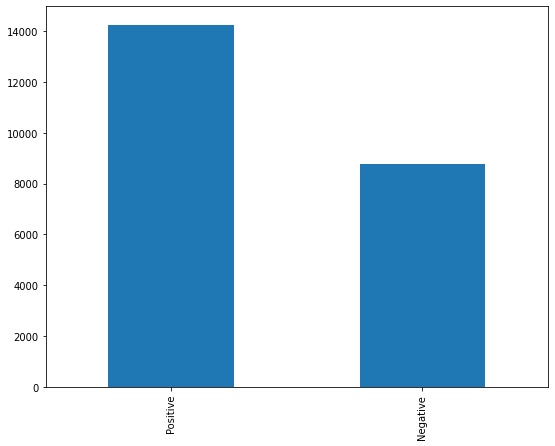

In [38]:
plt.figure(figsize=(9,7))
df['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [39]:
df_pos=df[df['Sentiment']=='Positive']
df_neg=df[df['Sentiment']=='Negative']

In [40]:
df_pos.shape

(14259, 2)

In [41]:
df_neg.shape

(8787, 2)

In [42]:
df_pos_bal=df_pos.sample(df_neg.shape[0])

In [43]:
df_pos_bal.shape

(8787, 2)

In [44]:
df_balanced=pd.concat([df_neg,df_pos_bal])

In [45]:
df_balanced.sample(5)

,Review_pre,Sentiment
18427,kefalonia corfu absolutely terrible experienc...,Negative
22882,chicago paris via reykjav husband flew airlin...,Positive
4703,copenhagen vagar faroe islands atlantic airway...,Positive
6781,canceled flight due covid refuse give refund ...,Negative
2515,great flight air new zealand easy check onlin...,Positive


In [46]:
df_balanced.shape

(17574, 2)

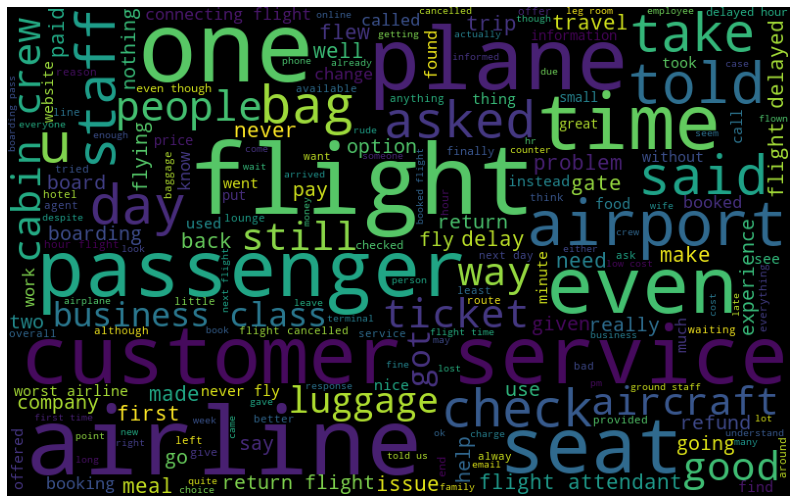

In [47]:
plt.figure(figsize=(15,9))
all_sen=' '.join([sentence for sentence in df_balanced['Review_pre']])
wordcloud_all=WordCloud(width=800,height=500,random_state=42,max_font_size=100).generate(all_sen)
plt.imshow(wordcloud_all)
plt.axis('off')
plt.show()

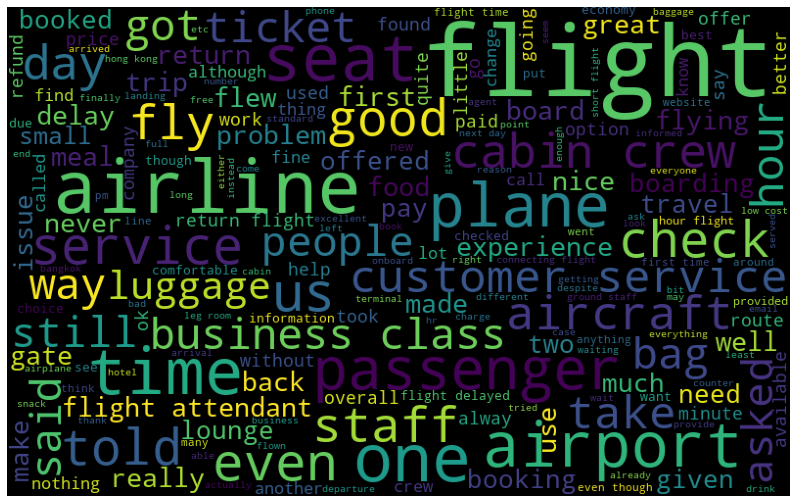

In [48]:
plt.figure(figsize=(15,9))
pos_sen=' '.join(df_balanced['Review_pre'][df_balanced['Sentiment']=='Positive'].tolist())
wordcloud_pos=WordCloud(width=800,height=500,random_state=42,max_font_size=100).generate(pos_sen)
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.show()

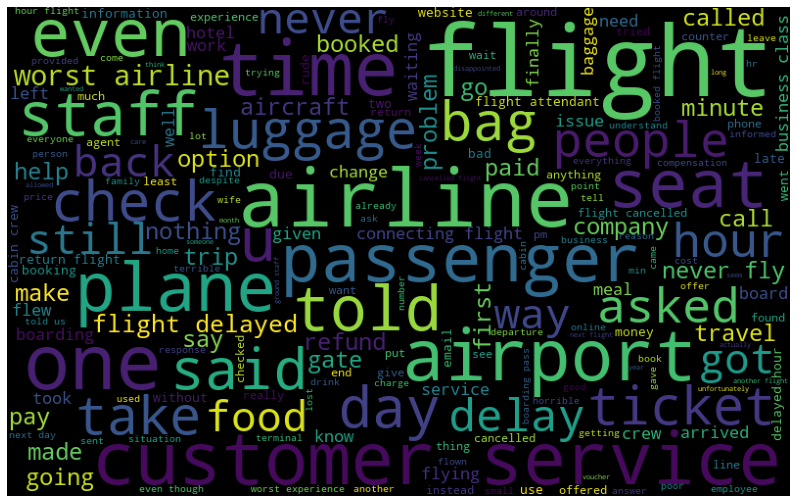

In [49]:
plt.figure(figsize=(15,9))
neg_sen=' '.join(df_balanced['Review_pre'][df_balanced['Sentiment']=='Negative'].tolist())
wordcloud_neg=WordCloud(width=800,height=500,random_state=42,max_font_size=100).generate(neg_sen)
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.show()

In [50]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df_balanced['Review_pre'])

In [51]:
tokenizer.word_index

{'flight': 1,
 'airline': 2,
 'service': 3,
 'time': 4,
 'us': 5,
 'would': 6,
 'one': 7,
 'airport': 8,
 'hours': 9,
 'staff': 10,
 'check': 11,
 'get': 12,
 'flights': 13,
 'plane': 14,
 'air': 15,
 'even': 16,
 'seats': 17,
 'seat': 18,
 'crew': 19,
 'food': 20,
 'customer': 21,
 'told': 22,
 'airlines': 23,
 'luggage': 24,
 'back': 25,
 'good': 26,
 'never': 27,
 'experience': 28,
 'fly': 29,
 'hour': 30,
 'boarding': 31,
 'could': 32,
 'delayed': 33,
 'passengers': 34,
 'cabin': 35,
 'ticket': 36,
 'got': 37,
 'first': 38,
 'another': 39,
 'day': 40,
 'return': 41,
 'worst': 42,
 'pay': 43,
 'said': 44,
 'also': 45,
 'minutes': 46,
 'take': 47,
 'booked': 48,
 'class': 49,
 'new': 50,
 'aircraft': 51,
 'business': 52,
 'way': 53,
 'due': 54,
 'like': 55,
 'next': 56,
 'asked': 57,
 'refund': 58,
 'people': 59,
 'arrived': 60,
 'ever': 61,
 'baggage': 62,
 'cancelled': 63,
 'gate': 64,
 'two': 65,
 'flying': 66,
 'still': 67,
 'go': 68,
 'delay': 69,
 'bag': 70,
 'trip': 71,
 'made

In [52]:
sequences=tokenizer.texts_to_sequences(df_balanced['Review_pre'])

In [53]:
sequences[0]

[91,
 28,
 3004,
 63,
 13,
 84,
 1570,
 2495,
 162,
 417,
 272,
 2790,
 3582,
 41,
 65,
 338,
 142,
 103,
 1,
 63,
 113,
 272,
 111,
 2790,
 3582,
 77,
 1046,
 1,
 25,
 184,
 3582,
 8547,
 2790,
 1189,
 38,
 1,
 77,
 1046,
 215,
 65,
 9,
 41,
 1,
 37,
 103,
 1,
 63,
 580,
 77,
 2282,
 772,
 1,
 7852,
 2445,
 599,
 2790,
 86,
 5135,
 1630,
 2445,
 2790,
 109,
 133,
 13,
 2495,
 162,
 658,
 2518,
 303,
 91]

In [54]:
len(sequences)

17574

In [55]:
b=[]
for i in sequences:
    b.append(len(i))

In [56]:
print(max(b))

484


In [57]:
maxlen=593
pad_sequences_t=pad_sequences(sequences,maxlen=maxlen,padding='post')

In [58]:
pad_sequences_t

array([[  91,   28, 3004, ...,    0,    0,    0],
       [2790, 4135, 1692, ...,    0,    0,    0],
       [1362, 2790,  151, ...,    0,    0,    0],
       ...,
       [ 808, 1178, 1245, ...,    0,    0,    0],
       [ 244,   61,    2, ...,    0,    0,    0],
       [ 118,  559, 3571, ...,    0,    0,    0]])

In [59]:
pad_sequences_t[0]

array([  91,   28, 3004,   63,   13,   84, 1570, 2495,  162,  417,  272,
       2790, 3582,   41,   65,  338,  142,  103,    1,   63,  113,  272,
        111, 2790, 3582,   77, 1046,    1,   25,  184, 3582, 8547, 2790,
       1189,   38,    1,   77, 1046,  215,   65,    9,   41,    1,   37,
        103,    1,   63,  580,   77, 2282,  772,    1, 7852, 2445,  599,
       2790,   86, 5135, 1630, 2445, 2790,  109,  133,   13, 2495,  162,
        658, 2518,  303,   91,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [60]:
len(pad_sequences_t)

17574

In [61]:
text_split=[i.split() for i in df_balanced['Review_pre']]

In [62]:
text_split[0]

['bad',
 'experience',
 'rerouted',
 'cancelled',
 'flights',
 'last',
 'weekend',
 'adria',
 'airways',
 'original',
 'route',
 'ljubljana',
 'sarajevo',
 'return',
 'two',
 'weeks',
 'received',
 'email',
 'flight',
 'cancelled',
 'offered',
 'route',
 'change',
 'ljubljana',
 'sarajevo',
 'via',
 'munich',
 'flight',
 'back',
 'changed',
 'sarajevo',
 'pristina',
 'ljubljana',
 'accepted',
 'first',
 'flight',
 'via',
 'munich',
 'ok',
 'two',
 'hours',
 'return',
 'flight',
 'got',
 'email',
 'flight',
 'cancelled',
 'rebook',
 'via',
 'hotline',
 'accept',
 'flight',
 'croatian',
 'zagreb',
 'reached',
 'ljubljana',
 'later',
 'organize',
 'transport',
 'zagreb',
 'ljubljana',
 'cost',
 'book',
 'flights',
 'adria',
 'airways',
 'heard',
 'financial',
 'situation',
 'bad']

In [63]:
DIM=100
w2v_model=gensim.models.Word2Vec(text_split,vector_size=DIM,window=10,min_count=1)

In [64]:
w2v_model.wv['good']

array([ 1.241307  ,  0.6192358 , -1.6370928 , -1.4208908 , -1.0839065 ,
        0.68425554,  2.5895872 ,  1.4008937 ,  0.70002574, -0.9901332 ,
        0.81444174,  0.9008524 , -1.2944505 , -0.6694666 , -1.0464401 ,
       -1.0370569 ,  0.20792675,  0.54377556, -1.365836  , -1.283415  ,
        0.35384423, -0.64871365, -0.71418536, -0.79683733, -0.29214668,
       -0.60305274,  0.67929316, -2.9733644 , -2.106083  , -0.6429245 ,
       -0.76965016,  1.1880766 ,  0.21209711, -0.068246  , -1.8891143 ,
        3.1337063 , -1.4106213 ,  1.573555  , -1.3376942 , -0.9539108 ,
        1.0296984 ,  0.50453717,  2.2316275 , -1.0180501 , -1.3157035 ,
        0.49988264, -1.531697  , -0.6306987 ,  0.85076326,  2.1904366 ,
       -2.2395287 , -1.7263657 , -1.0608447 ,  0.42834717, -1.7378266 ,
        1.3398055 , -0.2987674 , -0.63217545, -0.58824223, -0.9586039 ,
        1.2649202 , -0.23347914,  2.7011287 , -1.209052  , -0.6018506 ,
       -1.1171046 , -0.44101128,  1.5514069 ,  2.128771  ,  1.30

In [65]:
len(w2v_model.wv['good'])

100

In [66]:
w2v_model.wv.most_similar('good')

[('great', 0.8888213634490967),
 ('ok', 0.8675221800804138),
 ('decent', 0.8450263738632202),
 ('excellent', 0.8321141004562378),
 ('okay', 0.8240805268287659),
 ('nice', 0.7938193082809448),
 ('perfect', 0.7893902659416199),
 ('quite', 0.7813116908073425),
 ('pleasant', 0.7804901003837585),
 ('average', 0.7691776752471924)]

In [67]:
w2v_model.wv.most_similar('phone')

[('calling', 0.880774974822998),
 ('chat', 0.869197428226471),
 ('hung', 0.8673250079154968),
 ('call', 0.8601464033126831),
 ('center', 0.8522940874099731),
 ('contact', 0.8476987481117249),
 ('centre', 0.8471985459327698),
 ('number', 0.8458148837089539),
 ('calls', 0.8364374041557312),
 ('tried', 0.827725350856781)]

In [68]:
w2v_model.wv.similarity(w1='laptop',w2='phone')

0.118653275

In [69]:
w2v_model.wv.similarity(w1='sport',w2='football')

0.4352741

In [70]:
w2v_model.wv.vectors

array([[ 3.15926909e-01, -1.64596677e+00,  1.10018206e+00, ...,
        -9.42375481e-01,  1.38817513e+00,  1.54640779e-01],
       [-9.65777636e-01, -5.80341697e-01,  9.23780143e-01, ...,
         5.28331816e-01, -9.59655643e-01,  1.84351444e-01],
       [ 8.62568855e-01, -8.49415004e-01, -6.63515091e-01, ...,
         9.07849193e-01,  2.68070388e+00, -1.21968329e+00],
       ...,
       [-1.88320072e-03, -1.89248230e-02, -1.32278316e-02, ...,
        -1.80825274e-02,  1.61656309e-02, -5.43320272e-03],
       [-6.48257416e-03,  1.51306465e-02,  9.05807316e-03, ...,
        -3.56096998e-02,  1.16258105e-02,  1.91810932e-02],
       [-2.62102541e-02,  9.66813008e-04, -3.80449649e-03, ...,
        -1.32510753e-03, -6.70202018e-04,  3.06368805e-02]], dtype=float32)

In [71]:
w2v_model.wv.vectors[0]

array([ 0.3159269 , -1.6459668 ,  1.100182  , -0.04372994, -1.5767928 ,
        0.4322395 ,  1.6627002 ,  1.3386469 , -1.7381471 , -1.4135886 ,
        1.8554966 ,  1.1704695 , -0.9951735 , -1.1121296 , -1.2261593 ,
       -0.8682074 , -0.19444485,  1.7781376 , -1.4782717 , -0.14463612,
        0.50778127, -0.8333371 ,  0.06389687, -1.0570452 ,  1.7186238 ,
       -0.81186676,  0.40179121, -0.49643442, -0.982022  ,  0.5925693 ,
       -1.2538438 ,  1.1553205 ,  2.2147675 ,  0.44676206,  1.3841958 ,
        0.51220524, -0.73662764, -3.6929827 , -1.3929698 , -0.5391431 ,
       -1.6238132 ,  1.6515629 , -0.3878683 , -0.9402592 , -0.38323468,
        0.15882018,  0.78572536,  0.5967665 ,  0.16680448, -0.5800678 ,
       -0.83142203, -1.235405  ,  1.0386604 ,  0.16067094,  1.7423512 ,
       -1.9932628 , -1.5972153 , -0.4414369 ,  0.31142494,  0.2121448 ,
        1.1701819 , -0.72024614,  1.4717269 , -2.4298189 ,  0.07472449,
       -0.10414448,  0.07711388,  2.2725818 , -1.1879315 ,  0.79

In [72]:
len(w2v_model.wv.vectors)

26175

In [73]:
vocab_size=len(tokenizer.word_index)+1

In [74]:
vocab_size

26176

In [75]:
def get_weight_matrix(model):
    weight_matrix=np.zeros((vocab_size,DIM))
    for word,index in tokenizer.word_index.items():
        weight_matrix[index]=model.wv[word]
        return weight_matrix

In [76]:
embedding_vectors=get_weight_matrix(w2v_model)

In [77]:
embedding_vectors[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [78]:
embedding_vectors[1]

array([ 0.31592691, -1.64596677,  1.10018206, -0.04372994, -1.57679284,
        0.4322395 ,  1.66270018,  1.33864689, -1.73814714, -1.41358864,
        1.85549664,  1.17046952, -0.99517351, -1.11212957, -1.22615933,
       -0.8682074 , -0.19444485,  1.77813756, -1.47827172, -0.14463612,
        0.50778127, -0.83333713,  0.06389687, -1.05704522,  1.71862376,
       -0.81186676,  0.40179121, -0.49643442, -0.98202199,  0.59256929,
       -1.25384378,  1.15532053,  2.21476746,  0.44676206,  1.3841958 ,
        0.51220524, -0.73662764, -3.69298267, -1.39296985, -0.53914309,
       -1.62381315,  1.65156293, -0.38786829, -0.94025922, -0.38323468,
        0.15882018,  0.78572536,  0.59676647,  0.16680448, -0.58006781,
       -0.83142203, -1.23540497,  1.03866041,  0.16067094,  1.74235117,
       -1.99326277, -1.59721529, -0.44143689,  0.31142494,  0.21214481,
        1.17018187, -0.72024614,  1.47172689, -2.42981887,  0.07472449,
       -0.10414448,  0.07711388,  2.27258182, -1.18793154,  0.79

In [79]:
embedding_vectors.shape

(26176, 100)

In [80]:
df_balanced['Sentiment']=df_balanced['Sentiment'].replace({'Positive':1,'Negative':0})

In [81]:
df_balanced.sample(5)

,Review_pre,Sentiment
4510,return flight lagos nigeria london th july dep...,0
14264,flight delayed absolutely zero communication ...,1
9635,flight hours delayed lost check baggage updat...,0
7538,never mistreated like airline like need take ...,1
19622,flown saa taag flights taag bad unfortunately ...,0


In [82]:
X_train,X_test,y_train,y_test=train_test_split(pad_sequences_t,df_balanced['Sentiment'],test_size=0.2,random_state=42,
                                              stratify=df_balanced['Sentiment'])

In [83]:
epochs=12
learning_rate=0.1
decay_rate=learning_rate/epochs
momentum=0.8
sgd=SGD(learning_rate=learning_rate,momentum=momentum,decay=decay_rate,nesterov=False)
model=Sequential()
model.add(Embedding(vocab_size,output_dim=DIM,embeddings_initializer=Constant(embedding_vectors),trainable=False))
model.add(Conv1D(filters=32,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))

C:\Users\power\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [84]:
model.compile(optimizer=sgd,
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [85]:
hist=model.fit(X_train,y_train,epochs=epochs,validation_split=0.2,batch_size=64,verbose=1)

Epoch 1/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 216ms/step - accuracy: 0.5099 - loss: 0.6954 - val_accuracy: 0.4936 - val_loss: 0.6975
Epoch 2/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 208ms/step - accuracy: 0.5246 - loss: 0.6928 - val_accuracy: 0.4936 - val_loss: 0.6872
Epoch 3/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 211ms/step - accuracy: 0.5855 - loss: 0.6726 - val_accuracy: 0.7390 - val_loss: 0.5370
Epoch 4/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 38s 215ms/step - accuracy: 0.7207 - loss: 0.5543 - val_accuracy: 0.7781 - val_loss: 0.4706
Epoch 5/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 212ms/step - accuracy: 0.7724 - loss: 0.4822 - val_accuracy: 0.7927 - val_loss: 0.4392
Epoch 6/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 212ms/step - accuracy: 0.8148 - loss: 0.4150 - val_accuracy: 0.8318 - val_loss: 0.3851
Epoch 7/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 38s 214ms/step - accuracy: 0.8444 - loss: 0.3722 - val_accuracy: 0.8332 - val_loss: 0.3677
Epoch 8/12
176/176 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - accuracy: 0.8645 - loss: 0

In [86]:
model.evaluate(X_test,y_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8726 - loss: 0.3279


[0.32739195227622986, 0.8745377063751221]

In [87]:
y_predict=model.predict(X_test)

110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step


In [88]:
y_predict

array([[0.98779035],
       [0.99773794],
       [0.99781895],
       ...,
       [0.8860686 ],
       [0.03692928],
       [0.0234805 ]], dtype=float32)

In [89]:
y_predict=np.where(y_predict>0.5,1,0)

In [90]:
y_predict

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

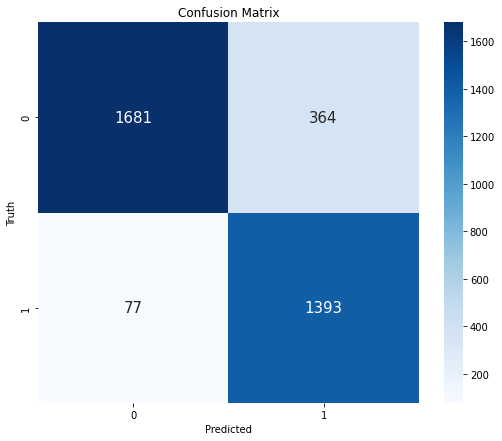

In [96]:
plt.figure(figsize=(9,7))
cm=confusion_matrix(y_predict,y_test)
sns.heatmap(cm,annot=True,square=True,cbar=True,annot_kws={'size':15},fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [97]:
print(classification_report(y_predict,y_test))

              precision    recall  f1-score   support

           0       0.96      0.82      0.88      2045
           1       0.79      0.95      0.86      1470

    accuracy                           0.87      3515
   macro avg       0.87      0.88      0.87      3515
weighted avg       0.89      0.87      0.88      3515



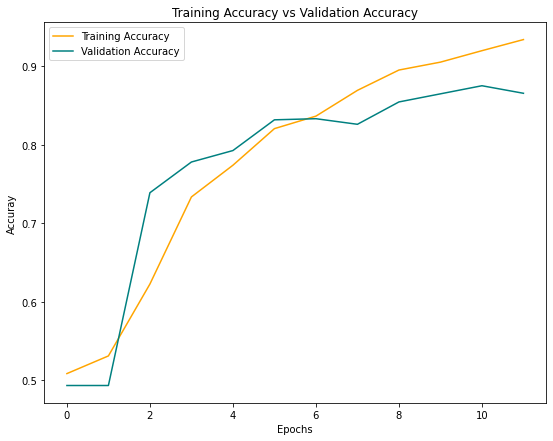

In [102]:
plt.figure(figsize=(9,7))
plt.plot(hist.history['accuracy'],color='orange',label='Training Accuracy')
plt.plot(hist.history['val_accuracy'],color='teal',label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuray')
plt.legend()
plt.show()

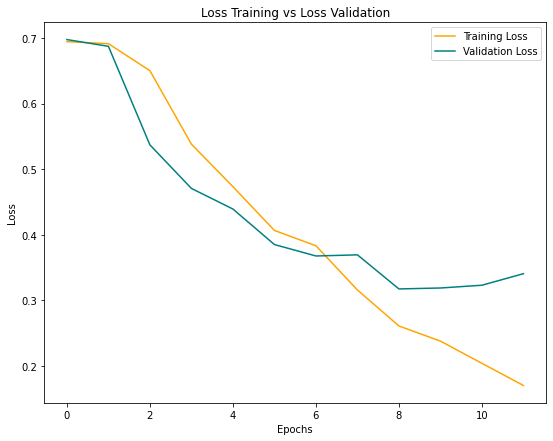

In [103]:
plt.figure(figsize=(9,7))
plt.plot(hist.history['loss'],color='orange',label='Training Loss')
plt.plot(hist.history['val_loss'],color='teal',label='Validation Loss')
plt.title('Loss Training vs Loss Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()